In [133]:
import mbuild as mb
import deepsmiles

import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.stats import maxwell
import warnings
warnings.filterwarnings('ignore')

# SMILES vs DeepSMILES:

## Examples:

Benzene with a butyl side chain:

### Smiles: c1cc(CCCC)ccc1  
### Deep Smiles: cccCCCC))))ccc6

**Repo**: https://github.com/baoilleach/deepsmiles

`pip install --upgrade deepsmiles`

**This Notebook:** https://github.com/chrisjonesBSU/poly-smiles

In [181]:
def convert_smiles(smiles=False, deep=False):   
    '''
    smiles and deep must be str format
    Converts from SMILES to DeepSMILES and vice versa.
    Whichever has a string provided, will convert to the other.
    If strings are proivded for both, then nothing happens
    '''
    
    converter = deepsmiles.Converter(rings=True, branches=True)
    if smiles and deep:
        print('Only provide a string for one of smiles or deep')
        return()
    if smiles: # Convert from SMILES to DeepSMILES
        deep_string = converter.encode(smiles)
        return deep_string
    if deep: # Convert from DeepSMILES to SMILES
        smiles_string = converter.decode(deep)
        return smiles_string 
    
    
def poly_smiles(monomer_string, length=2, ftype = 'mol2', string_only=True,
                energy_min=False, save=False, visualize=False):
    
    # Find how many branch-brackets are required at polymerization site
    atom_count = 0
    bracket_count = 0
    for s in monomer_string:
        if s.isalpha():
            atom_count += 1    
        if s == ')':
            bracket_count += 1 
    if bracket_count == 0:
        brackets = ')' * atom_count
    elif bracket_count != 0:
        brackets = ')' * (atom_count - bracket_count)
       
    # Find index num of poly site on modified DEEP SMILES string
    monomer_list = list(monomer_string)
    if '*' not in monomer_list:
        return(print('ERROR: Identify the wanted polymerization site using *x*'))
    key_indices = [index for index, value in enumerate(monomer_list) if value == '*']  
    if len(key_indices) != 2:   # Checks for only a single given poly site
        return(print('ERROR: Select only one polymerization site using *x*'))
    if key_indices[1] - key_indices[0] != 2:   # Check that the * are surrounding only a single atom
        return(print('ERROR: Select only one polymerization site using *x*'))
    monomer_list[key_indices[1]] = '{}' + '{}'.format(brackets) # Create poly site+brackets to the right of the atom
    monomer_list.remove('*')
    template = ''.join(monomer_list)  # Monomer string with the needed {} and without second * in the string
    monomer_list.remove('{}' + '{}'.format(brackets))
    monomer = ''.join(monomer_list)  # Pure deepsmiles monomer string without {} or *
    # What is the difference between monomer and monomer_string without **??
    
    # Loop & format polymer
    polymer = '{}'
    for i in range(0, length):
        if i == length - 1:
            polymer = polymer.format(monomer)
            break
        polymer = polymer.format(template)

    polymer_smiles = convert_smiles(deep = polymer)
    compound = mb.load(polymer_smiles, smiles = True)
    if string_only:
        return(polymer_smiles)
    if energy_min:
        compound.energy_minimize(steps = 25, forcefield='GAFF', algorithm = 'md')
    if visualize:
        compound.visualize().show()  
    if save:
        file_name = "comp_{}mer.{}".format(length, ftype)
        compound.save(file_name, overwrite = True)
    return compound


def count_brackets(string):
    atom_count = 0
    bracket_count = 0
    for s in string:
        if s.isalpha():
            atom_count += 1    
        if s == ')':
            bracket_count += 1 
    if bracket_count == 0:
        brackets = ')' * atom_count
    elif bracket_count != 0:
        brackets = ')' * (atom_count - bracket_count)
    return brackets


def viz(smiles_string, deep = True, energy_min = False):
    '''
    Lets you quickly visualize a smiles or deepsmiles string
    '''
    if deep:
        smiles_string = convert_smiles(deep = smiles_string)
    comp = mb.load(smiles_string, smiles = True)
    if energy_min:
        comp.energy_minimize(algorithm='md', steps=100)
    comp.visualize().show()
    
    
def polydisperse_system(system_dict=None, distribution=None, smiles=None, num_mols=None, pdi=None):
    
    system_compounds = []
    if system_dict:
        for monomer in system_dict:
            for length in system_dict[monomer]:
                num = system_dict[monomer][length]
                polymer = poly_smiles(monomer, length, string_only=False)
                for i in range(num):
                    system_compounds.append(polymer)
    
    if all(distribution):
        for length, prob in enumerate(distribution):
            polymer = poly_smiles(smiles, length+1, string_only=False)
            for i in range(int(round(prob * num_mols,0))):
                system_compounds.append(polymer)
                
    if pdi:
        pass

    system = mb.fill_box(system_compounds, [1 for i in system_compounds], density=50)
    return system            
    

In [128]:
#poly_smiles needs a smiles string in the DeepSmiles format; use this to convert
p3ht = 'c1scc(CCCCCC)c1'
p3ht_deep = convert_smiles(smiles=p3ht)
print('SMILES Format:')
print(p3ht)
print()
print('DeepSMILES Format:')
print(p3ht_deep)
viz(p3ht_deep)

SMILES Format:
c1scc(CCCCCC)c1

DeepSMILES Format:
csccCCCCCC))))))c5


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [130]:
# Use poly_smiles function to try out different polymerization sites, visualize to check outcome
p3htmer, p3htmer_smiles = poly_smiles('cs*c*cCCCCCC))))))c5', length=10, string_only=False, visualize=True)
print(p3htmer_smiles)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

c%10sc(c9sc(c8sc(c7sc(c6sc(c5sc(c4sc(c3sc(c2sc(c1scc(CCCCCC)c1)c(CCCCCC)c2)c(CCCCCC)c3)c(CCCCCC)c4)c(CCCCCC)c5)c(CCCCCC)c6)c(CCCCCC)c7)c(CCCCCC)c8)c(CCCCCC)c9)c(CCCCCC)c%10


In [6]:
ptb7 = 'CCCCC(CC)COC(=O)c1sc2c(scc2c1F)c3sc4c(OCC(CC)CCCC)c5ccsc5c(OCC(CC)CCCC)c4c3'
ptb7_deep = convert_smiles(smiles=ptb7)
print(ptb7_deep)
viz(ptb7_deep)

CCCCCCC))COC=O)csccscc5c8F)))))csccOCCCC))CCCC)))))))cccsc5cOCCCC))CCCC)))))))c9c%12


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [7]:
poly_smiles('ccccOCCCC))CCCC)))))))cscccscCOCCCCCC))))CC)))))=O))cF)c5*c*s8))))))))cc5cOCCCC))CCCC)))))))c9s%12',
           string_only=False,
           visualize=True,
           length=10)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

< 1032 particles, non-periodic, 1081 bonds, id: 140068884244816>

In [58]:
ptb7_10mer = poly_smiles('ccccOCCCC))CCCC)))))))cscccscCOCCCCCC))))CC)))))=O))cF)c5*c*s8))))))))cc5cOCCCC))CCCC)))))))c9s%12',
           length=10)

print('SMILES Format:')
print()
print(ptb7_10mer)
print()
print('DeepSMILES Format:')
print()
print(convert_smiles(smiles = ptb7_10mer))

SMILES Format:

c%50cc%49c(OCC(CC)CCCC)c%48sc(c%47c1sc(C(OCC(CCCC)CC)=O)c(F)c1c(c%46cc%45c(OCC(CC)CCCC)c%44sc(c%43c2sc(C(OCC(CCCC)CC)=O)c(F)c2c(c%42cc%41c(OCC(CC)CCCC)c%40sc(c%39c3sc(C(OCC(CCCC)CC)=O)c(F)c3c(c%38cc%37c(OCC(CC)CCCC)c%36sc(c%35c4sc(C(OCC(CCCC)CC)=O)c(F)c4c(c%34cc%33c(OCC(CC)CCCC)c%32sc(c%31c5sc(C(OCC(CCCC)CC)=O)c(F)c5c(c%30cc%29c(OCC(CC)CCCC)c%28sc(c%27c6sc(C(OCC(CCCC)CC)=O)c(F)c6c(c%26cc%25c(OCC(CC)CCCC)c%24sc(c%23c7sc(C(OCC(CCCC)CC)=O)c(F)c7c(c%22cc%21c(OCC(CC)CCCC)c%20sc(c%19c8sc(C(OCC(CCCC)CC)=O)c(F)c8c(c%18cc%17c(OCC(CC)CCCC)c%16sc(c%15c9sc(C(OCC(CCCC)CC)=O)c(F)c9c(c%14cc%13c(OCC(CC)CCCC)c%12sc(c%11c%10sc(C(OCC(CCCC)CC)=O)c(F)c%10cs%11)cc%12c(OCC(CC)CCCC)c%13s%14)s%15)cc%16c(OCC(CC)CCCC)c%17s%18)s%19)cc%20c(OCC(CC)CCCC)c%21s%22)s%23)cc%24c(OCC(CC)CCCC)c%25s%26)s%27)cc%28c(OCC(CC)CCCC)c%29s%30)s%31)cc%32c(OCC(CC)CCCC)c%33s%34)s%35)cc%36c(OCC(CC)CCCC)c%37s%38)s%39)cc%40c(OCC(CC)CCCC)c%41s%42)s%43)cc%44c(OCC(CC)CCCC)c%45s%46)s%47)cc%48c(OCC(CC)CCCC)c%49s%50

DeepSMILES

## Creating polydisperse systems:

In [9]:
# Generate a system with 3 different sizes of p3ht:

p3ht = 'cs*c*cCCCCCC))))))c5' # Specify polymerization site with **
p3ht_d = {4:3, 6:8, 8:2}  # polymer_length:number_of_polymers
system_d = {p3ht:p3ht_d}

system = polydisperse_system(system_dict=system_d)
system.visualize()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [10]:
# Creating a mixture:

ptb7 = 'ccccOCCCC))CCCC)))))))cscccscCOCCCCCC))))CC)))))=O))cF)c5*c*s8))))))))cc5cOCCCC))CCCC)))))))c9s%12'
p3ht = 'cs*c*cCCCCCC))))))c5'
ptb7_d = {4:2, 6:4, 8:2}  # polymer_length:number_of_polymers
p3ht_d = {4:2, 6:5, 8:3}
system_d = {ptb7:ptb7_d,
           p3ht:p3ht_d}

system = polydisperse_system(system_dict=system_d)
system.visualize()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

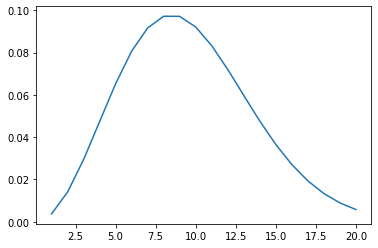

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [182]:
pdf = maxwell.pdf(np.arange(1,21,1), loc=0, scale=6)
plt.plot(np.arange(1,21,1), pdf)
plt.show()
system = polydisperse_system(smiles = 'cs*c*cCCCCCC))))))c5', distribution=pdf, num_mols=50)
system.visualize().show()

## More things to do with DeepSMILES and string formatting:

In [11]:
import json

In [12]:
with open('itic.json') as f:
    itic_dict = json.load(f)

In [13]:
print(itic_dict['smiles'])
print(itic_dict['deep_smiles'])
print(itic_dict['template'])
mb.load(itic_dict['smiles'], smiles=True).visualize()

C6c4cc3c2sc1ccsc1c2Cc3cc4c7sc5ccsc5c67
Cccccscccsc5c8Cc%11cc%15cscccsc5c%248
C{}cc{}ccscc{}c{}sc5c8C{}c%11c{}c%15cscc{}c{}sc5c%248


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [126]:
def build_molecule(backbone, branches, random_order=True, possible_branches=8, num_unique=4):
    '''
    
    '''
    if random_order:
        random.shuffle(branches)
    branches = branches[:num_unique] * (possible_branches // num_unique)
    branches_deep = [convert_smiles(smiles=b) for b in branches]
    brackets = [count_brackets(branch) for branch in branches_deep]
    with_brackets = [branch+'{}'.format(brackets[n]) for n, branch in enumerate(branches_deep)]
    mol_deep = backbone.format(*with_brackets)
    mol_smiles = convert_smiles(deep=mol_deep)
    #print('Smiles String: {}'.format(mol_smiles))
    comp = mb.load(mol_smiles, smiles=True)
    
    return comp

In [78]:
# 4 Different branch-like structures:

hexane = 'CCCCCC'
hexanol_ethane = 'OCC(CC)CCCC'
acetamide = 'CCCC(=O)N'
hydrazide = 'CC(=O)NNN'
thiophene_benzene = 'CC(c1ccccc1)(c1sccc1)'
fluoro_group = 'CC(=N)CC(F)(F)(F)'
anethole = 'CC=C(c1ccc(OC)cc1)'
methanethiosulfonate ='CSS(C)(=O)=O'
fluoropropionic_acid = 'CC(F)C(O)=O'
butanol = 'CCCC(O)'

branches = [hexane,
           hexanol_ethane,
           acetamide,
           hydrazide,
           thiophene_benzene,
           fluoro_group,
           anethole,
           methanethiosulfonate,
           fluoropropionic_acid,
           butanol]

In [125]:
for i in range(10):
    num_unique = [2, 4, 8] # This backbone can have up to 8 branches; set how many unique structures to use
    random.shuffle(num_unique) # shuffle num_unique, first element is passed into build_molecule
    comp = build_molecule(backbone=itic_dict['template'], branches=branches, num_unique=num_unique[0])
    comp.visualize().show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Possible Features:

    - Generate polydisperse system from a single smiles string and a PDI value  
    
    - Add end group functionality to the polyer function  
    
    - Move all of the DeepSMILES stuff behind the scenes
        - Allow the user to only work with the normal SMILES syntax